# Testing if I can make something better than GeoEnrich quickly

The goal is to make something that works the same way as `geoenrich` but in a much more modular and general-purpose way.

The constraints are:
- Must be able to get an area around a point (which we'll call a "seascape" from now on)
- Must be able to compute a summary of that seascape
- Must scale well to large amounts of points
- Shouldn't make multiple requests for the same "background". E.g.: if we want to get the bathymetry seascape, we should only request one map and then cut it up locally (to avoid DDoS-ing the data server)

## Get a GLORYS square near a series of points

In [18]:
import math
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

import xarray as xr
import copernicusmarine as cmems

import xscape as xscp

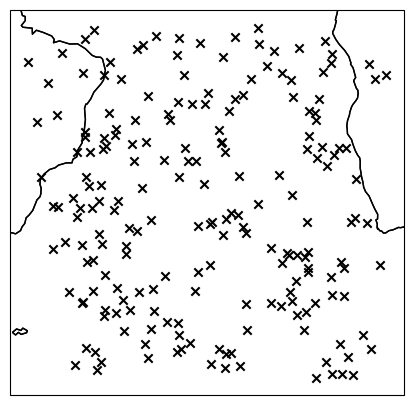

In [19]:
# Generate random coordinates
n_points = 10

points = xscp.generate_points(200, (-50, 20), (-60, 0))

fig, ax = plt.subplots(1,1,figsize=(10,5), subplot_kw={'projection':ccrs.Robinson()})

ax.coastlines()
xscp.plotting.plot_points(points)


In [20]:
# Glorys data request
seascape_size = 1 # degrees
gridsize = 1/12
extent = xscp.get_request_extent(points, seascape_size, gridsize)
# data_request = {
#     'dataset_id': 'cmems_mod_glo_phy_my_0.083deg_P1D-m',
#     'variables': ['zos', 'thetao', 'so', 'mlotst'],
#     'start_datetime': "2000-01-01",
#     'end_datetime' : "2000-12-31",
#     'maximum_latitude': extent['maximum_latitude'],
#     'minimum_latitude': extent['minimum_latitude'],
#     'maximum_longitude': extent['maximum_longitude'],
#     'minimum_longitude': extent['minimum_longitude'],
#     }

# glorys_ds = cmems.open_dataset(**data_request)

glorys_ds = xscp.get_glorys_da(
    ['zos', 'thetao', 'so', 'mlotst'],
    "2000-01-01",
    "2000-12-31",
    extent
)

INFO - 2025-01-29T14:56:07Z - Selected dataset version: "202311"
INFO - 2025-01-29T14:56:07Z - Selected dataset part: "default"


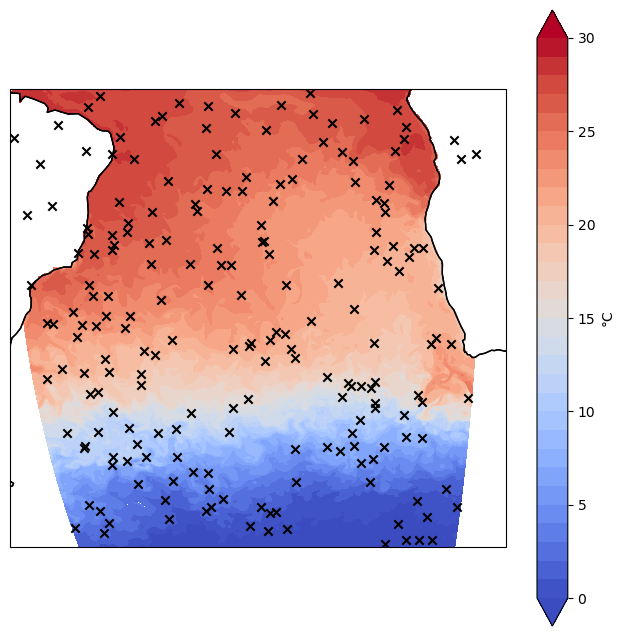

In [21]:
glorys_vars = glorys_ds.isel(time=0, depth=0)

fig, ax = plt.subplots(1,1,figsize=(8,8), subplot_kw={'projection':ccrs.Robinson()})

# Plot background
norm = mplc.Normalize(vmin=0, vmax=30, clip=False)
contourf_ = ax.contourf(glorys_vars.lon, glorys_vars.lat, glorys_vars.thetao, levels=[x for x in range(0,31)],\
                        transform=ccrs.PlateCarree(), norm=norm, cmap='coolwarm', extend='both');
cbar = fig.colorbar(contourf_, label="°C", ticks=[x*5 for x in range(0,7)], extend='both')

# Plot points
ax.coastlines()
xscp.plotting.plot_points(points)

plt.show()

In [22]:
glorys_var = glorys_vars.thetao # We will only have one variable at a time and so we should extract it at the start

xscp_da = xscp.create_xscp_da(
    points,
    seascape_size,
    glorys_var
)

In [23]:
xscp_da

<xarray.DataArray 'thetao' (seascape_idx: 200, ss_lon: 13, ss_lat: 13)> Size: 270kB
dask.array<concatenate, shape=(200, 13, 13), dtype=float64, chunksize=(1, 4, 7), chunktype=numpy.ndarray>
Coordinates:
    c_lon    (seascape_idx) float32 800B -23.92 -30.17 -48.17 ... -31.33 -0.9167
    c_lat    (seascape_idx) float32 800B -22.5 -51.25 -16.08 ... -44.75 -39.92
    ss_rlon  (ss_lon) float32 52B -0.5 -0.4167 -0.3333 ... 0.3333 0.4167 0.5
    ss_rlat  (ss_lat) float32 52B -0.5 -0.4167 -0.3333 ... 0.3333 0.4167 0.5
    ss_lon   (seascape_idx, ss_lon) float32 10kB -23.0 -22.92 ... -39.5 -39.42
    ss_lat   (seascape_idx, ss_lat) float32 10kB -24.42 -24.33 ... -0.5 -0.4167
Dimensions without coordinates: seascape_idx
Attributes:
    unit_long:      Degrees Celsius
    valid_min:      -32766
    units:          degrees_C
    long_name:      Temperature
    valid_max:      21306
    standard_name:  sea_water_potential_temperature

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8), subplot_kw={'projection':ccrs.Robinson()})

def plot_seascape(seascape):
    ax = plt.gca()
    return ax.contourf(seascape.longitude, seascape.latitude, seascape, levels=[x for x in range(0,31)],\
                        transform=ccrs.PlateCarree(), norm=norm, cmap='coolwarm', extend='both');

# Plot background
for idx, point in points.iterrows():
    # Get point background
    point_lon = point['lon']
    point_lat = point['lat']
    # NOT IMPLEMENTED YET:
    seascape = xscp_da.sel(c_lon=point_lon, c_lat=point_lat, method='nearest')
    print(seascape.shape())
    
    if seascape.size == 0:
        print("Empty seascape. Skipping plot.")
        continue

    contourf_ = plot_seascape(seascape)
    
cbar = fig.colorbar(contourf_, label="°C", ticks=[x*5 for x in range(0,7)], extend='both')

xscp.plotting.plot_points(points)